# Backpropagation in Multilayer Neural Networks

### Goals: 
- implementING a real gradient descent in `Numpy`

### Dataset:

- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [206]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

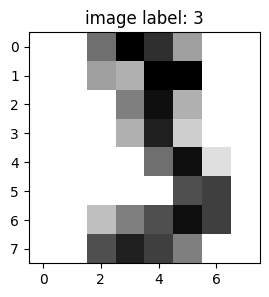

In [207]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [208]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]
[1.         0.91047427 

In [209]:
X_train.shape

(1527, 64)

In [210]:
X_train.dtype

dtype('float32')

In [211]:
X_test.shape

(270, 64)

In [212]:
y_train.shape

(1527,)

In [213]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [214]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [215]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [216]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [217]:
def softmax(X):
    """
    Argument:
    x -- A numpy matrix of shape (m,n)

    Returns:
    s -- A numpy matrix equal to the softmax of x, of shape (m,n)
    """
    # Apply exp() element-wise to X. Use np.exp(...).
    x_exp = np.exp(X)

    # Create a vector x_sum that sums each row of x_exp.
    x_sum = np.sum(x_exp, keepdims=True)

    # Compute softmax(x) by dividing x_exp by x_sum. It should automatically use numpy broadcasting.
    s = x_exp/x_sum

    ### END CODE HERE ###

    return s

Make sure that this works one vector at a time (and check that the components sum to one):

In [218]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [219]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.92957576e-01 3.33100158e-04 2.24441121e-06]
 [1.65840803e-05 6.69049552e-03 9.29172262e-14]]


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [220]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [221]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [222]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [223]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [224]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    """Computes the negative log-likelihood loss for a given set of predictions and labels.

    Args:
        Y_true: A NumPy array of true labels.
        Y_pred: A NumPy array of predicted probabilities.

    Returns:
        A scalar value representing the negative log-likelihood loss.
    """
    # Ensure Y_pred is within a small range to avoid log(0)
    epsilon = 1e-15
    Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)

    # # Compute the log-likelihood of the predictions and apply the negative sign.
    # log_likelihood = -np.sum(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))

    # # Return the negative log-likelihood.
    # return log_likelihood

    
    
    # Calculate the negative log likelihood
    nll_loss = -np.sum(Y_true * np.log(Y_pred))
    
    return nll_loss


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [225]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [226]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    # Ensure Y_pred is within a small range to avoid log(0)
    epsilon = 1e-15
    Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)

    # # Compute the log-likelihood of the predictions and apply the negative sign.
    # log_likelihood = -np.sum(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred), axis=1)

    # # Return the negative log-likelihood.
    # return log_likelihood

    
    
    # Calculate the negative log likelihood
    nll_loss = -np.sum(Y_true * np.log(Y_pred), axis=1)
    
    return nll_loss


In [227]:
# negative log likelyhood
def negative_log_likelihood(Y_true, Y_pred):
    
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    # Clip Y_pred to avoid log(0) and log(1) issues
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    
    # Calculate the negative log probabilities
    neg_log_probs = -np.log(Y_pred)
    
    # Multiply by Y_true to only keep the elements where Y_true is 1
    neg_log_likelihood = np.sum(neg_log_probs * Y_true)
    
    return neg_log_likelihood

In [228]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

[9.99200722e-16 1.00503359e-02 9.99200722e-16]


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [229]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [230]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

# print("train_loss type:", type(train_loss))
# print("train_acc type:", type(train_acc))
# print("test_acc type:", type(test_acc))

train_loss_mean = np.mean(train_loss)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss_mean, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.4121, train acc: 0.066, test acc: 0.081


Evaluate the randomly initialized model on the first example:

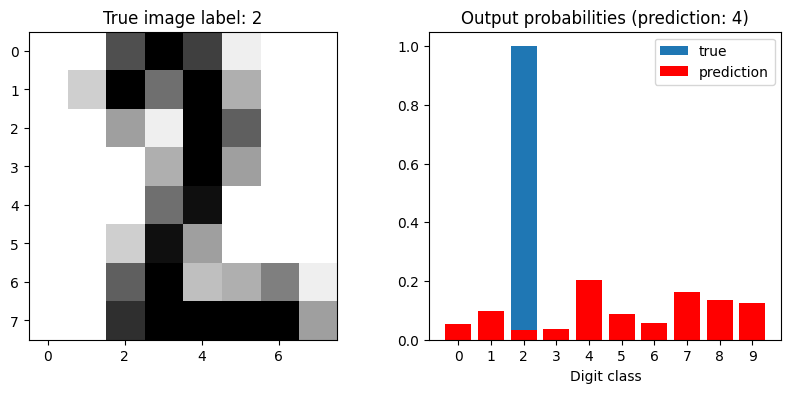

In [231]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx:sample_idx+1]).reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [232]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)

        train_loss_mean = np.mean(train_loss)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss_mean, train_acc.item(), test_acc.item()))

Update #0, train loss: 2.3782, train acc: 0.084, test acc: 0.096
Update #100, train loss: 1.3150, train acc: 0.681, test acc: 0.689
Update #200, train loss: 0.8658, train acc: 0.848, test acc: 0.874
Update #300, train loss: 0.6435, train acc: 0.899, test acc: 0.907
Update #400, train loss: 0.5364, train acc: 0.906, test acc: 0.926
Update #500, train loss: 0.4630, train acc: 0.917, test acc: 0.933
Update #600, train loss: 0.3998, train acc: 0.927, test acc: 0.937
Update #700, train loss: 0.3627, train acc: 0.933, test acc: 0.952
Update #800, train loss: 0.3422, train acc: 0.939, test acc: 0.944
Update #900, train loss: 0.3177, train acc: 0.940, test acc: 0.948
Update #1000, train loss: 0.2983, train acc: 0.946, test acc: 0.948
Update #1100, train loss: 0.2779, train acc: 0.949, test acc: 0.959
Update #1200, train loss: 0.2663, train acc: 0.948, test acc: 0.963
Update #1300, train loss: 0.2580, train acc: 0.951, test acc: 0.944
Update #1400, train loss: 0.2431, train acc: 0.957, test acc

Evaluate the trained model on the first example:

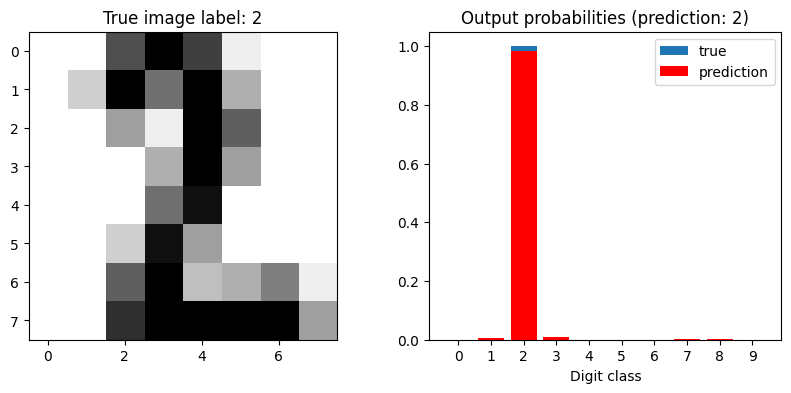

In [233]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

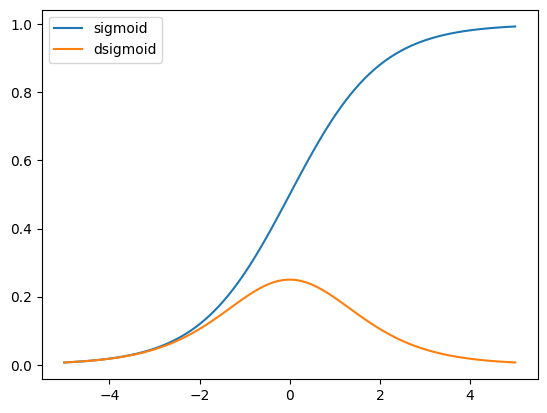

In [234]:
def sigmoid(X):
    """
    Compute the sigmoid function element-wise for an input array X.
    
    Args:
        X: NumPy array or scalar input.
        
    Returns:
        NumPy array of the same shape as X with sigmoid values.
    """
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    """
    Compute the derivative of the sigmoid function element-wise for an input array X.
    
    Args:
        X: NumPy array or scalar input.
        
    Returns:
        NumPy array of the same shape as X with derivative of sigmoid values.
    """
    sigmoid_X = sigmoid(X)
    return sigmoid_X * (1 - sigmoid_X)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward` now has a keep activations parameter to also return hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [235]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases for the hidden and output layers
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size, high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        self.output_size = output_size
    
    # def sigmoid(self, X):
    #     # Sigmoid activation function
    #     return 1 / (1 + np.exp(-X))

    # def softmax(self, X):
    #     # Softmax activation function
    #     if len(X.shape) == 1:
    #         expX = np.exp(X - np.max(X))  # Subtracting max(X) for numerical stability
    #         return expX / np.sum(expX)
    #     else:
    #         expX = np.exp(X - np.max(X, axis=1, keepdims=True))  # Subtracting max(X) for numerical stability
    #         return expX / np.sum(expX, axis=1, keepdims=True)
    #     # # Softmax activation function
    #     # expX = np.exp(X - np.max(X))  # Subtracting max(X) for numerical stability
    #     # return expX / np.sum(expX, axis=1, keepdims=True)
            
    def forward_keep_activations(self, X):

        # Forward pass with hidden layer activations and pre-activations
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        # z_o = np.dot(h, self.W_o) + self.b_o
        # y = softmax(z_o)
        y = np.zeros(shape=self.output_size)
        return y, h, z_h
        # # TODO
        # z_h = 0.
        # h = 0.
        # y = np.zeros(size=self.output_size)
        # return y, h, z_h
    
    

    def forward(self, X):
        # Forward pass without hidden layer activations and pre-activations
        y, h, z_h = self.forward_keep_activations(X)
        return y
    
    def loss(self, X, y):
        # Calculate the cross-entropy loss
        y_pred = self.forward(X)
        loss = -np.sum(y * np.log(y_pred + EPSILON)) / len(y)
        return loss

    def grad_loss(self, X, y_true):
        # Compute gradients of the loss with respect to all parameters
        y_pred, h, z_h = self.forward_keep_activations(X)
        
        # Output layer gradients
        dL_dy = -(y_true / (y_pred + EPSILON) - (1 - y_true) / (1 - y_pred + EPSILON))
        dL_dW_o = np.dot(h.T, dL_dy)
        dL_db_o = np.sum(dL_dy, axis=0)
        
        # Hidden layer gradients
        dL_dh = np.dot(dL_dy, self.W_o.T)
        dL_dz_h = dL_dh * h * (1 - h)  # Gradient of sigmoid activation
        dL_dW_h = np.dot(X.T, dL_dz_h)
        dL_db_h = np.sum(dL_dz_h, axis=0)
        
        gradients = {"W_h": dL_dW_h, "b_h": dL_db_h, "W_o": dL_dW_o, "b_o": dL_db_o}
        return gradients

    def train(self, X, y, learning_rate):
        # Update weights and biases using gradients and learning rate
        grads = self.grad_loss(X, y)
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X))
        return np.mean(y_preds == y)

In [236]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [237]:
y_one_hot = one_hot(n_classes, y_train)
model.loss(X_train, y_one_hot)

18.420680743952367

In [238]:
model.accuracy(X_train, y_train)

0.09888670595939751

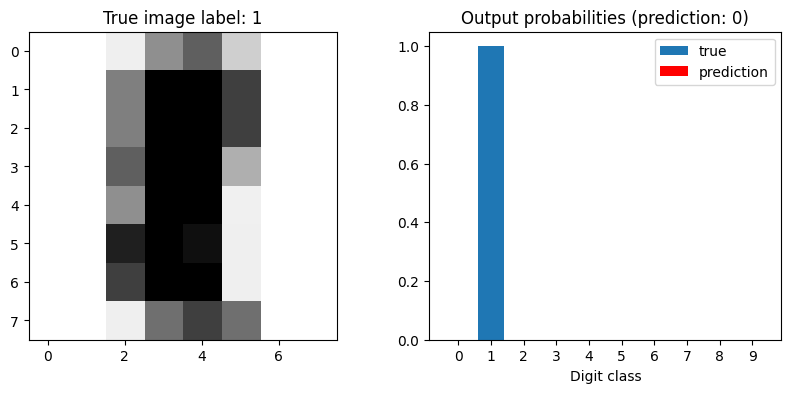

In [239]:
plot_prediction(model, sample_idx=5)

In [ ]:
y_one_hot = one_hot(n_classes, y_train)
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_one_hot))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Text(0.5, 1.0, 'Training loss')

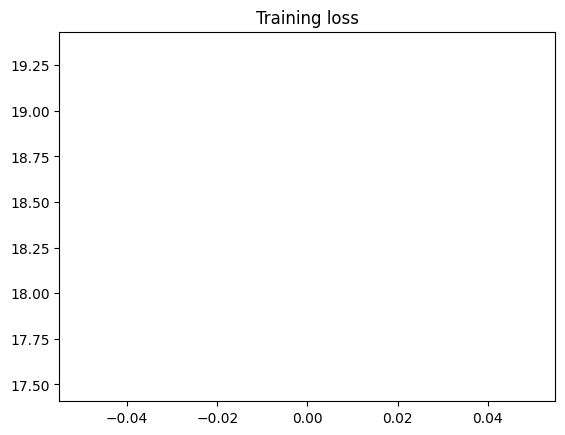

In [241]:
plt.plot(losses)
plt.title("Training loss")

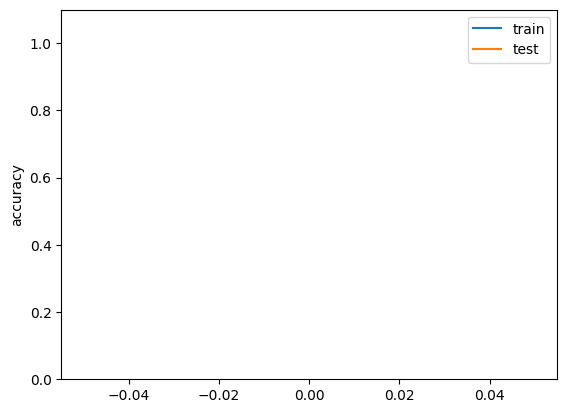

In [242]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

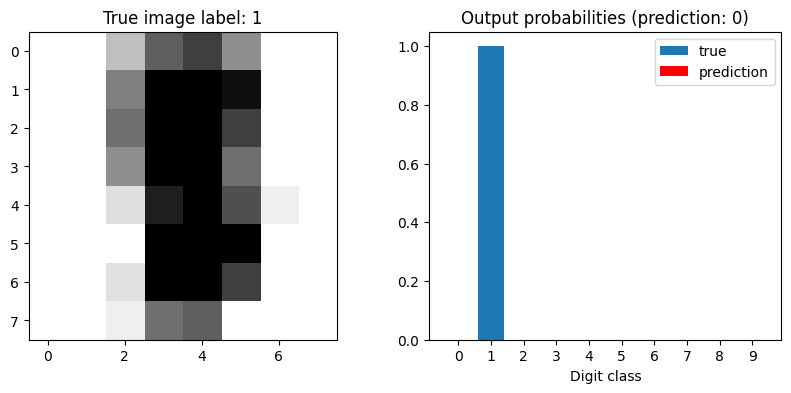

In [243]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum


### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).